In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')
import matplotlib

In [2]:
from f_statistics import *
from f_preprocessing import *
# from f_figures import *
# from f_run_evaluation import *
# from f_effective_cover import *
from f_significance_calculation_correlation import *


In [3]:
fol='/home/vanoorschot/work/fransje/confess_paper/'

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)
colors =['gainsboro','none']
cmap_grey2 = LinearSegmentedColormap.from_list('cm',colors, N=2)
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)

colors =['whitesmoke','whitesmoke','whitesmoke']
cmap_whitesmoke = LinearSegmentedColormap.from_list('cm',colors, N=3)

In [5]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [6]:
cmap = cm.get_cmap('RdBu', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_rdbu = ListedColormap(color_list)

In [7]:
tl_0_1 = ['0.0','','0.2','','0.4','','0.6','','0.8','','1.0']
tl_0_2 = ['0.0','','0.04','','0.08','','0.12','','0.16','','0.2']
tl_02 = ['-0.20','','-0.12','','-0.04','','0.04','','0.12','','0.20']
tl_01 = ['-0.10','','-0.06','','-0.02','','0.02','','0.06','','0.10']
tl_800=['0','','160','','320','','480','','640','','800']
tl_500=['0','','100','','200','','300','','400','','500']
tl_1500=['0','','300','','600','','900','','1200','','1500']
tl_05=['0.0','','0.1','','0.2','','0.3','','0.4','','0.5']
tl_005=['-0.05','','-0.03','','-0.01','','0.01','','0.03','','0.05']
tl_003=['-0.03','','-0.0015','','0','','0.0015','','0.03']

In [8]:
f_mod = f'{fol}/data/htessel_output/IAK5'
mod = xr.open_dataset(f'{f_mod}/o_veg_1999_2018_climatology.nc')
m = mod.var66.mean(dim='time')
mn = m.notnull()

### CORRELATION MAPS - ALL MONTHS

In [9]:
def corr_e_allmonths(exp_name1,exp_name2,dt,name1,name2):
    for sig in ['sig_yes']:#,'sig_no']:
        ref_data = 'DOLCE_v3'
        start_year = '1999'
        end_year = '2018'
        var = 'hfls'
        reps = 1000
        tp = 'ia anomalies'
        #load quantiles
        tp2 = tp.replace(" ", "_")
        q = xr.open_dataset(f'{fol}/data/htessel_output//sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

        # calculate correlation
        rd=calculate_correlation(fol,ref_data,tp,start_year, end_year,var,name1,name2,dt)
        r=rd[0]
        r1=rd[1]
        r2=rd[2]

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -
        aps_ps = aps.sum().values/asig.sum().values # percentage of +
        ans_ps = ans.sum().values/asig.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        rnull = r.isnull()

        lvls = np.linspace(-0.05,0.05,21)
        lvls3 = np.linspace(-0.05,0.05,11)
        lvls2 = np.linspace(-0.05,0.05,2) 
        cm2 = plt.cm.get_cmap('Pastel2_r')

        # fig with stats
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.2)
        n = r.notnull()
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xticklabels(tl_005)
        ax.set_title(f'',size=14)
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)

        # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
        # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
        # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
        fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_stats.jpg',dpi=300,bbox_inches='tight')

        # fig without stats
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.2)
        n = r.notnull()
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xticklabels(tl_005)
        ax.set_title(f'',size=14)
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


In [10]:
def corr_sm_allmonths(exp_name1,exp_name2,dt,name1,name2):
    for sig in ['sig_yes']:#,'sig_no']: 
        start_year = '1999'
        end_year = '2018'
        reps=1000
        tp = f'ia anomalies'
        layer='layer1'
        th='60'
        #load quantiles
        tp2 = tp.replace(" ", "_")
        q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{start_year}_{end_year}_corr_{dt}_{th}.nc')

        # calculate correlation
        rd=calculate_correlation_SM_esa(fol,tp,start_year, end_year,name1,name2,layer,dt,th)    
        r=rd[0]
        r1=rd[1]
        r2=rd[2]

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -
        aps_ps = aps.sum().values/asig.sum().values # percentage of +
        ans_ps = ans.sum().values/asig.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        rnull = r.isnull()

        lvls = np.linspace(-0.05,0.05,21)
        lvls3 = np.linspace(-0.05,0.05,11)
        # lvls = np.linspace(-0.02,0.02,21)
        # lvls3 = np.linspace(-0.02,0.02,11)
        lvls2 = np.linspace(-0.05,0.05,2)
        cm2 = plt.cm.get_cmap('Pastel2_r')

        n = r.notnull()
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.2)
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xticklabels(tl_005)
        ax.set_title(f' anomaly SM correlation diff {exp_name2}-{exp_name1}',size=14)
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)

#         ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
#         ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
#         ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
        fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esa-cci_{dt}_{sig}_stats.jpg',dpi=300,bbox_inches='tight')

        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.2)
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xticklabels(tl_005)
        ax.set_title(f'',size=14)
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esa-cci_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


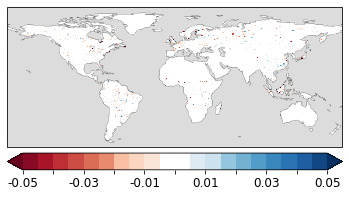

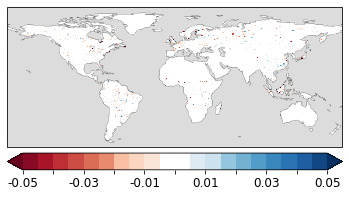

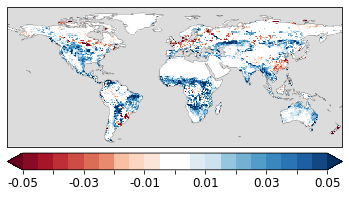

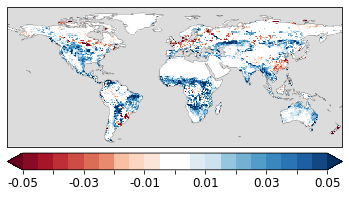

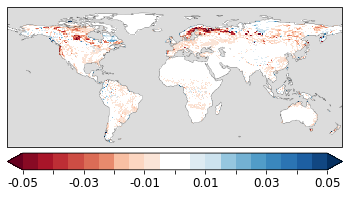

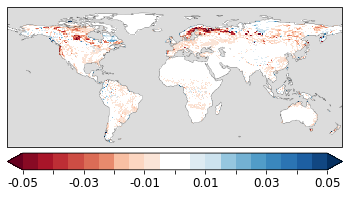

In [11]:
corr_e_allmonths('exp3','ex10','dt_no','CTR','IALC')
corr_e_allmonths('ex10','exp5','dt_yes','IALC','IAK5')
corr_e_allmonths('exp5','exp6','dt_yes','IAK5','IAKV')

/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewater

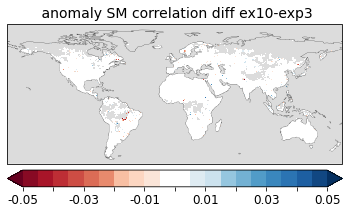

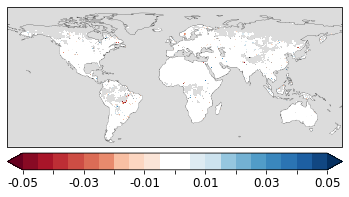

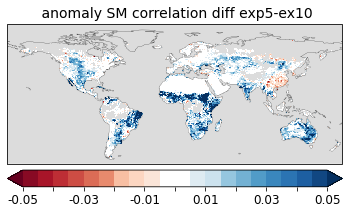

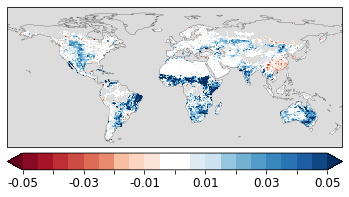

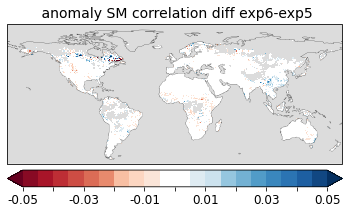

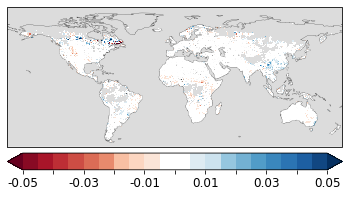

In [12]:
corr_sm_allmonths('exp3','ex10','dt_no','CTR','IALC')
corr_sm_allmonths('ex10','exp5','dt_yes','IALC','IAK5')
corr_sm_allmonths('exp5','exp6','dt_yes','IAK5','IAKV')

/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/xarray/core/nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/vanoorschot/miniconda3/envs/ewater

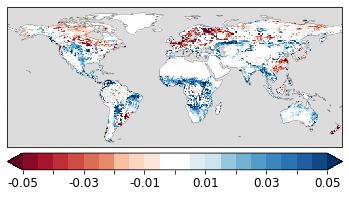

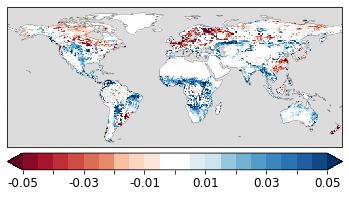

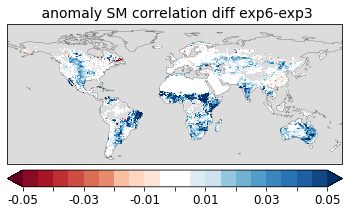

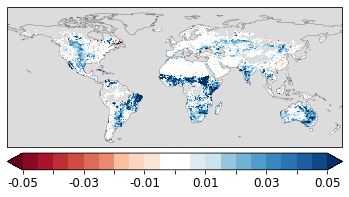

In [13]:
corr_e_allmonths('exp3','exp6','dt_yes','CTR','IAKV')
corr_sm_allmonths('exp3','exp6','dt_yes','CTR','IAKV')

### CORRELATION MAPS - SEASONS

In [14]:
def e_seasons_sig(sig,season,exp_name1,exp_name2,dt,name1,name2):
    sig = 'sig_yes'
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    reps=1000
    tp = f'ia anomalies {season}'

    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{season}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

    # calculate correlation
    rd=calculate_correlation_seasons(fol,ref_data,tp,start_year, end_year,var,name1,name2,season,dt)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]

    return(q,r,r1,r2)

In [15]:
def corr_e_seasons_r(exp_name1,exp_name2,name1,name2,dt):
    sig = 'sig_yes'
    fig = plt.figure(figsize=(24,10))
    lvls = np.linspace(0,1,21)
    lvls3 = np.linspace(0,1,11)
    lvls2 = np.linspace(-0.05,0.05,2)
    seasons = ['djf','mam','jja','son']
    seasons_up = ['DJF','MAM','JJA','SON']
    al = ['a','c','e','g']
    # cmap = cm.get_cmap('viridis_r')
    cmap = cm.get_cmap('YlGnBu')

    for i in range(len(seasons)):
        q,r,r1,r2 = e_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -
        aps_ps = aps.sum().values/asig.sum().values # percentage of +
        ans_ps = ans.sum().values/asig.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        n = r.notnull()
        ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree())
        plt.subplots_adjust(left=0.01,
                        bottom=0.01,
                        right=0.5,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.3)
        ax.coastlines(linewidth=0.2)
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='min',label=f'', pad=0.04, ticks=lvls3, shrink=0.3)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_0_1)
        ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{E}$ $r$ '+str(name1),size=16,loc='left')
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        
    fig.savefig(f'{fol}/output_figures/correlation_maps/corr_E_{exp_name1}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}.jpg',dpi=300,bbox_inches='tight')


In [16]:
def corr_e_seasons_rd(exp_name1,exp_name2,name1,name2,dt):
    sig = 'sig_yes'
    fig = plt.figure(figsize=(24,10))
    lvls = np.linspace(-0.05,0.05,21)
    lvls3 = np.linspace(-0.05,0.05,11)
    lvls2 = np.linspace(-0.05,0.05,2)
    seasons = ['djf','mam','jja','son']
    seasons_up = ['DJF','MAM','JJA','SON']
    al = ['b','d','f','h']
    for i in range(len(seasons)):
        q,r,r1,r2 = e_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -
        aps_ps = aps.sum().values/asig.sum().values # percentage of +
        ans_ps = ans.sum().values/asig.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        n = r.notnull()
        ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree())
        plt.subplots_adjust(left=0.01,
                        bottom=0.01,
                        right=0.5,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.3)
        ax.coastlines(linewidth=0.2)
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.04, ticks=lvls3, shrink=0.3)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_005)
        ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{E}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
                
        # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=8)
        # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=8)
        # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=8)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


In [17]:
def sm_seasons_sig(sig,season,exp_name1,exp_name2,dt,name1,name2):
    start_year = '1999'
    reps=1000
    tp = f'ia anomalies {season}'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{season}_{start_year}_{end_year}_corr_{dt}_{th}.nc')
    # plot correlation
    rd=calculate_correlation_SM_esa_seasons(fol,tp,start_year, end_year,name1,name2,layer,season,dt,th)
    r=rd[0]
    r1=rd[1]
    r2=rd[2]
    
    return(q,r,r1,r2)

In [18]:
def corr_sm_seasons_r(exp_name1,exp_name2,name1,name2,dt):
    sig = 'sig_yes'
    fig = plt.figure(figsize=(24,10))
    lvls = np.linspace(0,1,21)
    lvls3 = np.linspace(0,1,11)
    lvls2 = np.linspace(-0.05,0.05,2)
    seasons = ['djf','mam','jja','son']
    seasons_up = ['DJF','MAM','JJA','SON']
    al = ['a','c','e','g']
    cmap = cm.get_cmap('YlGnBu')

    for i in range(len(seasons)):
        q,r,r1,r2 = sm_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        n = r.notnull()
        ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree())
        plt.subplots_adjust(left=0.01,
                        bottom=0.01,
                        right=0.5,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.3)
        ax.coastlines(linewidth=0.2)
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='min',label=f'', pad=0.04, ticks=lvls3, shrink=0.3)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_0_1)
        ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{SM}_{\mathrm{s}}$ $r$ '+str(name1),size=16,loc='left')
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corr_SM_{exp_name1}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}.jpg',dpi=300,bbox_inches='tight')


In [19]:
def corr_sm_seasons_rd(exp_name1,exp_name2,name1,name2,dt):
    sig = 'sig_yes'
    fig = plt.figure(figsize=(24,10))
    lvls = np.linspace(-0.05,0.05,21)
    lvls3 = np.linspace(-0.05,0.05,11)
    lvls2 = np.linspace(-0.05,0.05,2)
    seasons = ['djf','mam','jja','son']
    seasons_up = ['DJF','MAM','JJA','SON']
    al = ['b','d','f','h']
    for i in range(len(seasons)):
        q,r,r1,r2 = sm_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

        # calculate area percentages of results
        cube = r.to_iris()
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)

        # without significance
        r = r.where(r.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        ap = areas.where(r>0) # positive correlation diff - improvement
        an = areas.where(r<0) # negative correlation diff - deterioration
        ap_p = ap.sum().values/a.sum().values # percentage of +
        an_p = an.sum().values/a.sum().values # percentage of -

        # with significance
        rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
        rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

        rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
        areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
        areas = areas.where(areas.lat>-60) # exclude antarctica
        a = areas.where(r.notnull()) # all land points areas with data
        asum = a.sum().values # total land area with data

        asig = areas.where(rs2.notnull()) # all land points areas with data
        asigsum = asig.sum().values # total land area with data
        asigp = asigsum/asum
        aps = areas.where(rs2>0) # positive correlation diff - improvement
        ans = areas.where(rs2<0) # negative correlation diff - deterioration
        aps_p = aps.sum().values/a.sum().values # percentage of +
        ans_p = ans.sum().values/a.sum().values # percentage of -
        aps_ps = aps.sum().values/asig.sum().values # percentage of +
        ans_ps = ans.sum().values/asig.sum().values # percentage of -

        # mean + or - delta correlation
        rp = r.where(r>0).mean().values
        rn = r.where(r<0).mean().values

        rps = rs2.where(rs2>0).mean().values
        rns = rs2.where(rs2<0).mean().values

        n = r.notnull()
        ax = plt.subplot(4,1,i+1,projection=ccrs.PlateCarree())
        plt.subplots_adjust(left=0.01,
                        bottom=0.01,
                        right=0.5,
                        top=0.9,
                        wspace=0.1,
                        hspace=0.3)
        ax.coastlines(linewidth=0.2)
        cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
        cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
        cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        if (sig=='sig_yes'):
            # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
            cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
            # cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
        cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.04, ticks=lvls3, shrink=0.3)
        cbar.ax.tick_params(labelsize=14)
        cbar.ax.set_xticklabels(tl_005)
        ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{SM}_{\mathrm{s}}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
        ax.set_ylim(-60,90)
        ax.set_xlim(-180,180)
        
        # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=8)
        # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=8)
        # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=8)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


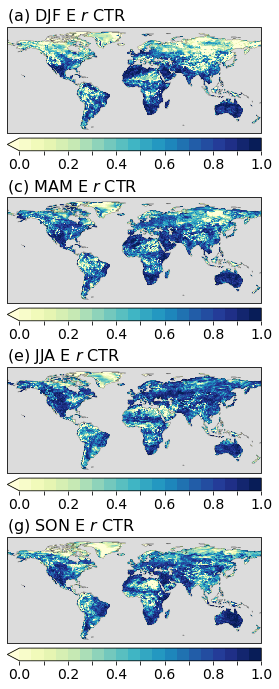

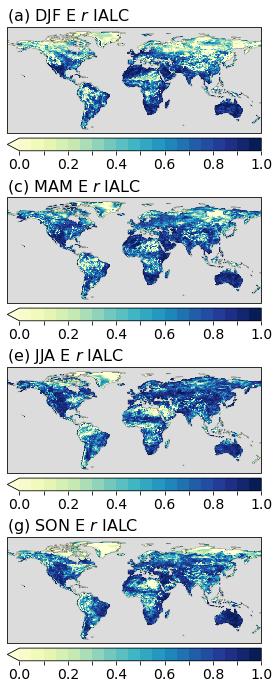

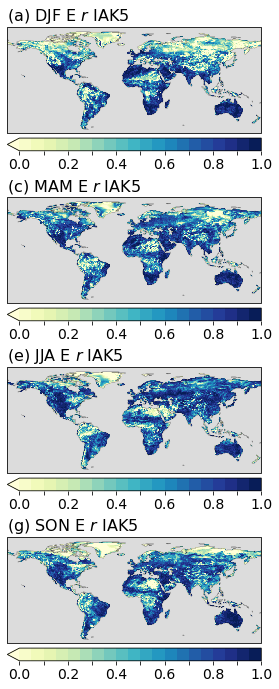

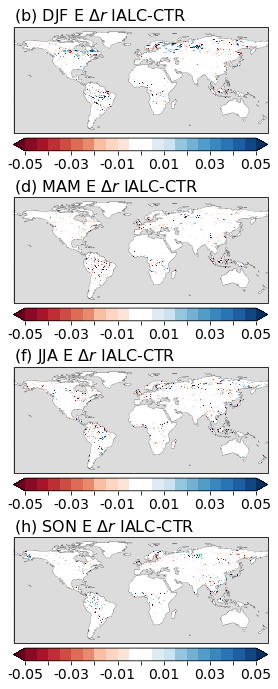

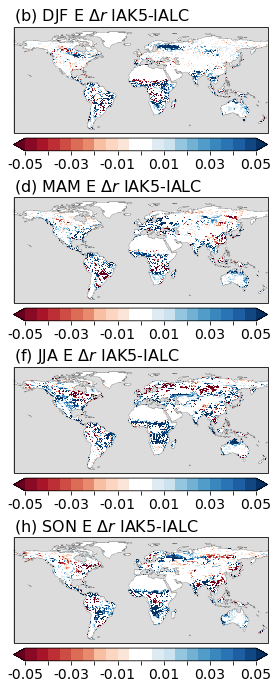

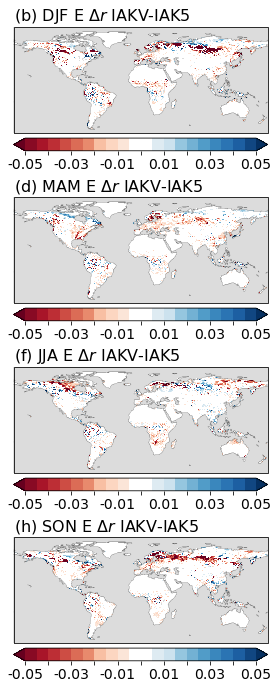

In [20]:
sig = 'sig_yes'
ref_data = 'DOLCE_v3'
start_year = '1999'
end_year = '2018'
reps=1000
corr_e_seasons_r('exp3','ex10','CTR','IALC','dt_no')
corr_e_seasons_r('ex10','exp5','IALC','IAK5','dt_yes')
corr_e_seasons_r('exp5','exp6','IAK5','IAKV','dt_yes')

corr_e_seasons_rd('exp3','ex10','CTR','IALC','dt_no')
corr_e_seasons_rd('ex10','exp5','IALC','IAK5','dt_yes')
corr_e_seasons_rd('exp5','exp6','IAK5','IAKV','dt_yes')

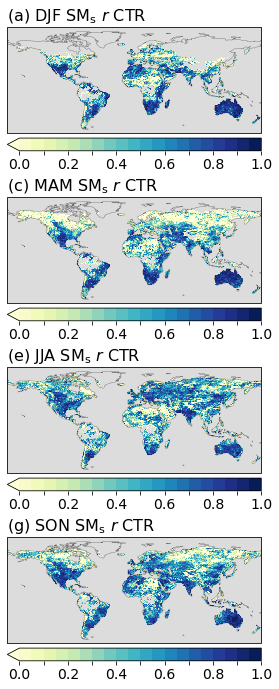

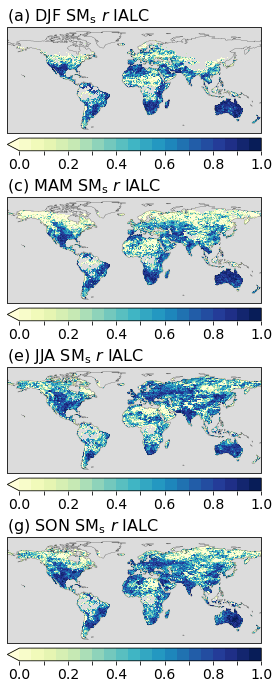

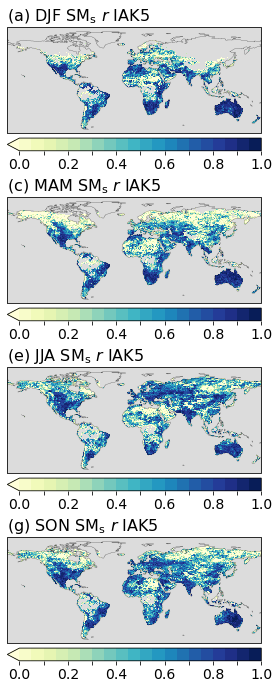

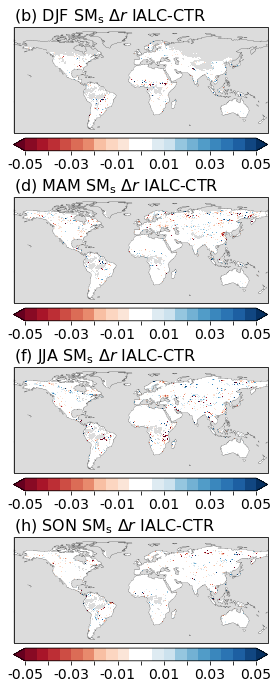

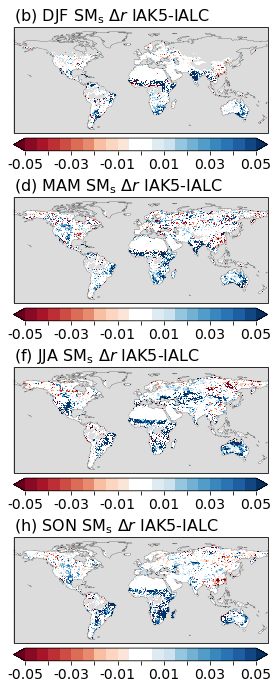

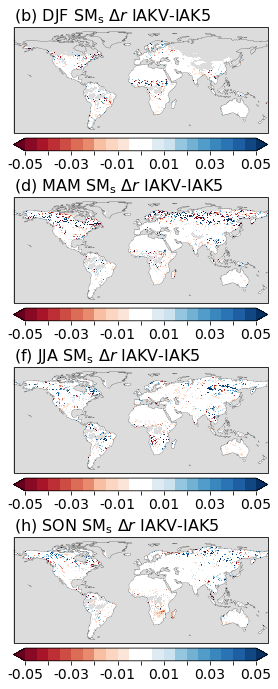

In [21]:
sig = 'sig_yes'
ref_data = 'DOLCE_v3'
start_year = '1999'
end_year = '2018'
reps=1000
corr_sm_seasons_r('exp3','ex10','CTR','IALC','dt_no')
corr_sm_seasons_r('ex10','exp5','IALC','IAK5','dt_yes')
corr_sm_seasons_r('exp5','exp6','IAK5','IAKV','dt_yes')

corr_sm_seasons_rd('exp3','ex10','CTR','IALC','dt_no')
corr_sm_seasons_rd('ex10','exp5','IALC','IAK5','dt_yes')
corr_sm_seasons_rd('exp5','exp6','IAK5','IAKV','dt_yes')

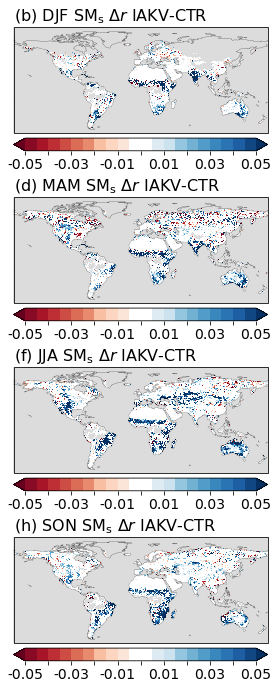

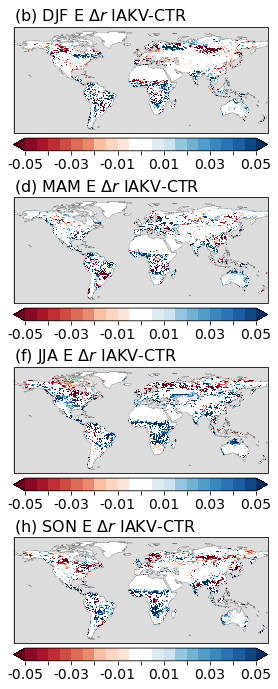

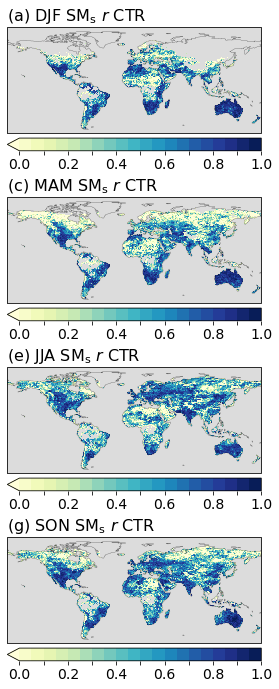

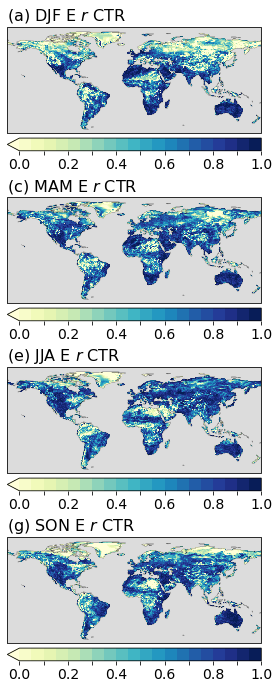

In [22]:
corr_sm_seasons_rd('exp3','exp6','CTR','IAKV','dt_yes')
corr_e_seasons_rd('exp3','exp6','CTR','IAKV','dt_yes')
corr_sm_seasons_r('exp3','exp6','CTR','IAKV','dt_yes')
corr_e_seasons_r('exp3','exp6','CTR','IAKV','dt_yes')

## EXP3-EXP6 E AND SM JJA DJF MAPS

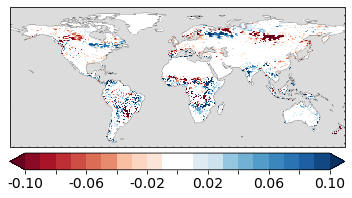

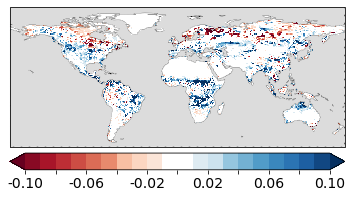

In [23]:
exp_name1,exp_name2='exp3','exp6'
dt = 'dt_yes'
name1,name2 = 'CTR','IAKV'
start_year = '1999'
end_year = '2018'
reps=1000
sig = 'sig_yes'
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','b']
for i in range(len(seasons)):
    q,r,r1,r2 = e_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{E}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    
    # ax.annotate(f'Sig: {np.int(asigp*100)}%',(-177,5), size=10)
    # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_{seasons[i]}.jpg',dpi=300,bbox_inches='tight')


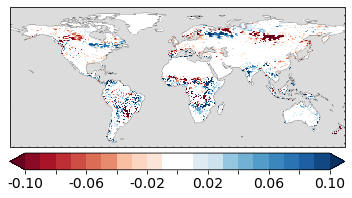

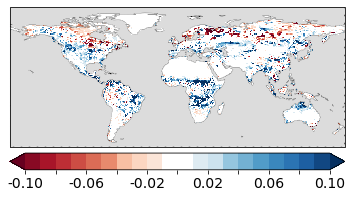

In [24]:
exp_name1,exp_name2='exp3','exp6'
dt = 'dt_yes'
name1,name2 = 'CTR','IAKV'
start_year = '1999'
end_year = '2018'
reps=1000
sig = 'sig_yes'
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','b']
for i in range(len(seasons)):
    q,r,r1,r2 = e_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{E}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    
    # ax.annotate(f'Sig: {np.int(asigp*100)}%',(-177,5), size=10)
    # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_{seasons[i]}.jpg',dpi=300,bbox_inches='tight')


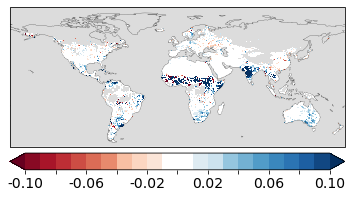

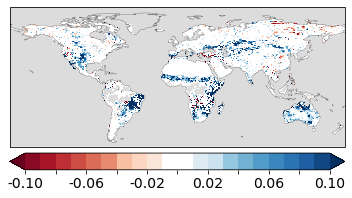

In [25]:
sig = 'sig_yes'
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
for i in range(len(seasons)):
    q,r,r1,r2 = sm_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro',add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{SM}_{\mathrm{s}}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    
    # ax.annotate(f'Sig: {np.int(asigp*100)}%',(-177,5), size=10)
    # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_p*100)}%',(-177,-40), size=10)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_p*100)}%',(-177,-55),size=10)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}_{sig}_{seasons[i]}.jpg',dpi=300,bbox_inches='tight')


### PLOT MAPS WITH REGIONS HIGHLIGHTED

In [26]:
# NE brazil
lat_minb,lat_maxb = -11,-3
lon_minb,lon_maxb = 316,325
lon_minb2 = lon_minb-360
lon_maxb2 = lon_maxb-360

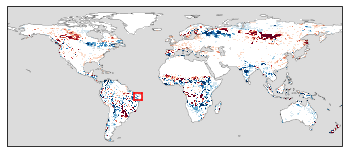

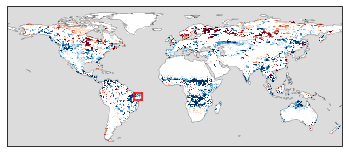

In [27]:
exp_name1,exp_name2='exp3','exp6'
dt = 'dt_yes'
name1,name2 = 'CTR','IAKV'
sig = 'sig_yes'
ref_data = 'DOLCE_v3'
start_year = '1999'
end_year = '2018'
reps=1000
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','b']
for i in range(len(seasons)):
    q,r,r1,r2 = e_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    # cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{E}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'r-')
    ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'r-')
    ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'r-')
    ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'r-')
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
    # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_{seasons[i]}.jpg',dpi=300,bbox_inches='tight')


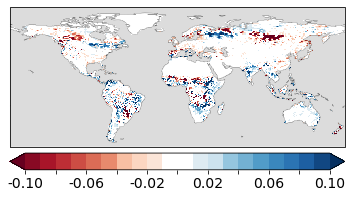

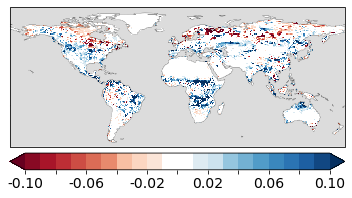

In [28]:
exp_name1,exp_name2='exp3','exp6'
dt = 'dt_yes'
name1,name2 = 'CTR','IAKV'
sig = 'sig_yes'
ref_data = 'DOLCE_v3'
start_year = '1999'
end_year = '2018'
reps=1000
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
al = ['a','b']
for i in range(len(seasons)):
    q,r,r1,r2 = e_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{E}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    # ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'r-')
    # ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'r-')
    # ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'r-')
    # ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'r-')
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
    # # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_E_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_{seasons[i]}_noregion.jpg',dpi=300,bbox_inches='tight')


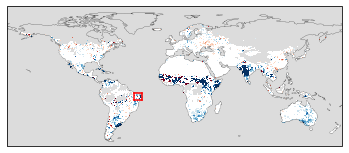

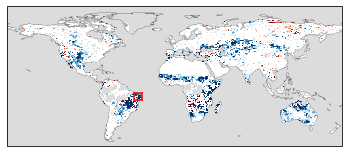

In [29]:
sig = 'sig_yes'
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
for i in range(len(seasons)):
    q,r,r1,r2 = sm_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'r-')
    ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'r-')
    ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'r-')
    ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'r-')
    # cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{SM}_{\mathrm{s}}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
    # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}_{sig}_{seasons[i]}.jpg',dpi=300,bbox_inches='tight')


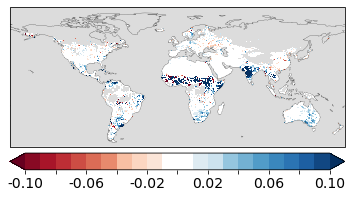

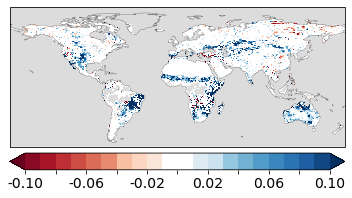

In [30]:
sig = 'sig_yes'
lvls = np.linspace(-0.1,0.1,21)
lvls3 = np.linspace(-0.1,0.1,11)
lvls2 = np.linspace(-0.1,0.1,2)
seasons = ['djf','jja']
seasons_up = ['DJF','JJA']
for i in range(len(seasons)):
    q,r,r1,r2 = sm_seasons_sig(sig,seasons[i],exp_name1,exp_name2,dt,name1,name2)

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    # ax.plot([lon_minb2,lon_maxb2],[lat_maxb,lat_maxb],'r-')
    # ax.plot([lon_minb2,lon_maxb2],[lat_minb,lat_minb],'r-')
    # ax.plot([lon_minb2,lon_minb2],[lat_minb,lat_maxb],'r-')
    # ax.plot([lon_maxb2,lon_maxb2],[lat_minb,lat_maxb],'r-')
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xticklabels(tl_01)
    # ax.set_title('('+str(al[i])+') '+str(seasons_up[i])+' $\mathrm{SM}_{\mathrm{s}}$ $\Delta r$ '+str(name2)+'-'+str(name1),size=16,loc='left')
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    
    # ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
    # # ax.annotate(f'+ $\Delta$$r$: {np.int(ap_p*100)}%',(-177,-10), size=10)
    # # ax.annotate(f'- $\Delta$$r$: {np.int(an_p*100)}%',(-177,-25),size=10)
    # ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
    # ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
    fig.savefig(f'{fol}/output_figures/correlation_maps/corrdiff_SM_{exp_name1}_{exp_name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esacci_{dt}_{sig}_{seasons[i]}_noregion.jpg',dpi=300,bbox_inches='tight')
